<a href="https://colab.research.google.com/github/abrarelidrisi/MRI-Segmentation/blob/main/3D_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Task 3 of the MRI Segmentation task:**

In [1]:
#Importing important libraries and loading our dataset (containing of MRI scans and the ground truth (Segmented)images

import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from scipy.io import loadmat
import sys
import matplotlib.pyplot as plt
from skimage.morphology import remove_small_objects, remove_small_holes, binary_dilation
from skimage.feature import canny
import scipy.ndimage as ndi
from sklearn.cluster import KMeans

In [2]:
#Since I'll be using edge detection algorithms like Canny later on, It's better to normalize our data so the algorithms can perform better and not put muc count to outliers
def normalizing(T1):
  slice_normalized = (T1 - np.min(T1)) / (np.max(T1) - np.min(T1))
  # slice_normalized = T1_normalized[...,slice_idx]
  return slice_normalized


In [3]:
#We now start the segmentation process, beginning with smotthing using Gaussian filter
def smoothing(slice_normalized):
  # Apply Gaussian smoothing
  slice_smoothed = cv2.GaussianBlur(slice_normalized, (5, 5), 0)

  #Uncomment to visualize the preprocessed slice
  # plt.imshow(slice_smoothed, cmap='gray')
  # plt.title("Preprocessed (smoothed) Slice")
  # plt.show()
  return slice_smoothed


In [4]:
#Applying Multi level Otsu

from skimage.filters import threshold_multiotsu
import numpy as np
import matplotlib.pyplot as plt

# Apply Multi-Otsu Thresholding
def otsu_thresholding(slice_smoothed):

    # Compute multi-Otsu thresholds
    thresholds = threshold_multiotsu(slice_smoothed)

    # Digitize the image into discrete regions
    thresholded = np.digitize(slice_smoothed, bins=thresholds)

    # Optional: Visualize thresholded result
    # plt.imshow(thresholded, cmap='viridis')
    # plt.title("Multi-Otsu Thresholding")
    # plt.colorbar(ticks=range(classes))
    # plt.show()

    return thresholded

In [5]:
# Showcasing the outcome of applying otsu on our smoothed slice
def showcase_thresholded(thresholded, slice_smoothed):
  thresholded_img = thresholded * slice_smoothed
  # plt.imshow(thresholded_img, cmap='gray')
  # plt.axis('off')
  # plt.title('Thresholded')
  # plt.show()
  return thresholded_img

In [6]:
#Applying Canny Edge detection to mainly handle the internal structure. We later note that using tools to fill holes and remove small objects has impressively increased our segmentation accuracy
def applying_canny(thresholded_img):
  thresholded_img = thresholded_img.flatten().reshape(-1,1)
  edges = canny(thresholded_img, sigma=2)
  # Dilate the edges
  edges = ndi.binary_dilation(edges)

  # Fill holes in the edges
  edges = ndi.binary_fill_holes(edges)

  # remove small objects
  edges = remove_small_objects(edges, min_size=100)
  # Plot the edges
  # plt.imshow(edges, cmap='gray')
  # plt.axis('off')
  # plt.title('Canny')
  # plt.show()
  return edges


In [7]:
# #Showcasing the effect of applying Canny edge detection to our image
def showcasing_canny(slice_normalized, edges):
  edges = edges.flatten().reshape(-1,1)
  img_thresholded = slice_normalized * edges[0]
  # plt.imshow(img_thresholded)
  # plt.axis('off')
  # plt.title('Masked Edges')
  # plt.show()
  return img_thresholded

In [8]:
#Define k-means segmentation so we can apply it to the image
def kmeans_segmentation(image, n_clusters=6):
    # Reshape the image to a 2D array
    X = image.reshape(-1, 1)

    # Fit KMeans to the data
    kmeans = KMeans(n_clusters=n_clusters, random_state=0)

    # Predict the labels for the data
    labels = kmeans.fit_predict(X)

    # Reshape the labels to the original image shape
    labels = labels.reshape(image.shape)

    # Get the centroids of the clusters
    centroids = kmeans.cluster_centers_

    # Order the centroids and return the indices
    order = np.argsort(centroids, axis=0)

    return labels, order

In [9]:
#Creating a temporal_mask dictionary so we can ensure efficient mapping
def temporal_mask_creation(cluster_labels, order):
  temporal_masks = {}
  temporal_masks["0"] = (cluster_labels == order[0]).astype(int)
  temporal_masks["1"] = (cluster_labels == order[1]).astype(int)
  temporal_masks["2"] = (cluster_labels == order[2]).astype(int)
  temporal_masks["3"] = (cluster_labels == order[3]).astype(int)
  temporal_masks["4"] = (cluster_labels == order[4]).astype(int)
  temporal_masks["5"] = (cluster_labels == order[5]).astype(int)
  return temporal_masks

In [10]:
#Defining functions to help in plotting our masks, as well as cobining the masks to give our final segmented output
def plot_masks(temporal_masks, rows=1, cols=2, slice_id = None):

    fig, axes = plt.subplots(rows, cols, figsize=(12, 6))

    fig.suptitle('Temporal Masks')

    flatten_axes = axes.flat
    for ax, (key, mask) in zip(flatten_axes, temporal_masks.items()):
        if slice_id is not None:
            mask = mask[:,:,slice_id]
        ax.imshow(mask, cmap='gray')
        ax.set_title(f'Mask: {key}')
        ax.axis('off')

    plt.tight_layout()
    # plt.show()

def temporal_masks2final_segmented_mask(temporal_masks, labels = range(6), slice_id = None):
    if slice_id is not None:
        segmented_labels = np.zeros_like(temporal_masks["0"][:,:,0])
    else:
        segmented_labels = np.zeros_like(temporal_masks["0"])

    # Accumulate all the temporal masks in the segmented_labels
    for label in labels:
        mask = temporal_masks[str(label)]
        if slice_id is not None:
            mask = mask[:,:,slice_id]
        segmented_labels[mask == 1] = label

    return segmented_labels

In [11]:
# Uncomment to showcase the masks
# plot_masks(temporal_masks, rows=2, cols=4)

In [12]:
#function to showcase our final segmented image
def showcase_segmented_image(temporal_masks):
  segmented_img = temporal_masks2final_segmented_mask(temporal_masks)

  # Plot the final segmented image
  # plt.imshow(segmented_img)
  # plt.title('Segmented Output')
  # plt.colorbar(ticks=range(6), label="Labels (0-5)")
  # plt.show()
  return segmented_img

In [13]:
#Defining our Dice metrics
def dice_coefficient(pred, truth):
    pred = pred > 0  # Ensure binary format
    truth = truth > 0  # Ensure binary format
    intersection = np.sum(pred * truth)
    return 2 * intersection / (np.sum(pred) + np.sum(truth))

In [14]:
#Defining our Jaccard metrics
def jaccard_index(pred, truth):
    pred = pred > 0
    truth = truth > 0
    intersection = np.sum(pred * truth)
    union = np.sum(pred + truth) - intersection
    return intersection / union

In [15]:
#Defining our accuracy metrics
def pixel_accuracy(pred, truth):

    pred = pred > 0  # Ensure binary format
    truth = truth > 0  # Ensure binary format

    correct = np.sum(pred == truth)  # Count matching pixels
    total = truth.size  # Total number of pixels
    return correct / total

In [16]:
#Showcasing the performance of our segmentation algoirthm vs. the ground truth
def compare_label_distributions(ground_truth, prediction, num_classes):

    # Count label occurrences in ground truth
    gt_labels, gt_counts = np.unique(ground_truth, return_counts=True)
    gt_distribution = np.zeros(num_classes)
    gt_distribution[gt_labels] = gt_counts

    # Count label occurrences in prediction
    pred_labels, pred_counts = np.unique(prediction, return_counts=True)
    pred_distribution = np.zeros(num_classes)
    pred_distribution[pred_labels] = pred_counts

    # Normalize to percentage if needed
    gt_percentage = (gt_distribution / np.sum(gt_distribution)) * 100
    pred_percentage = (pred_distribution / np.sum(pred_distribution)) * 100

    # Plot the distributions
    labels = [f"Class {i}" for i in range(num_classes)]
    x = np.arange(num_classes)

    plt.figure(figsize=(10, 6))

    # Bar plot
    plt.bar(x - 0.2, gt_percentage, width=0.4, label='Ground Truth (%)', color='blue')
    plt.bar(x + 0.2, pred_percentage, width=0.4, label='Prediction (%)', color='orange')

    # Add labels, legend, and title
    plt.xticks(x, labels)
    plt.xlabel("Class Labels")
    plt.ylabel("Percentage of Pixels (%)")
    plt.title("Label Distribution: Ground Truth vs Prediction")
    plt.legend()
    plt.tight_layout()
    plt.show()


num_classes = 6
# compare_label_distributions(ground_truth, segmented_img, num_classes)

In [17]:
#Defining a segmentation function that applies the whol steps
def full_segmentation(slice):
  slice_data = T1
  ground_truth = label

  slice_normalized = normalizing(T1)
  slice_smoothed = smoothing(slice_normalized)
  thresholded = otsu_thresholding(slice_smoothed)
  thresholded_img = showcase_thresholded(thresholded, slice_smoothed)
  edges = applying_canny(thresholded_img)
  img_thresholded = showcasing_canny(slice_normalized, edges)
  cluster_labels, order = kmeans_segmentation(thresholded_img, n_clusters=6)
  temporal_masks = temporal_mask_creation(cluster_labels, order)
  segmented_img = showcase_segmented_image(temporal_masks)
  dice_score = dice_coefficient(segmented_img, ground_truth)
  jaccard_score = jaccard_index(segmented_img, ground_truth)
  accuracy_score = pixel_accuracy(segmented_img, ground_truth)
  return temporal_masks, segmented_img, dice_score, jaccard_score, accuracy_score

In [18]:
# Load data
data = loadmat('Brain.mat')
T1 = data['T1']
label = data['label']

Slice [[ 6588.089]
 [ 7265.799]
 [ 7431.491]
 ...
 [13830.156]
 [14881.414]
 [16387.402]]
Dice Coefficient: 0.922
Jaccard Index: 5.890
Pixel Accuracy: 0.894


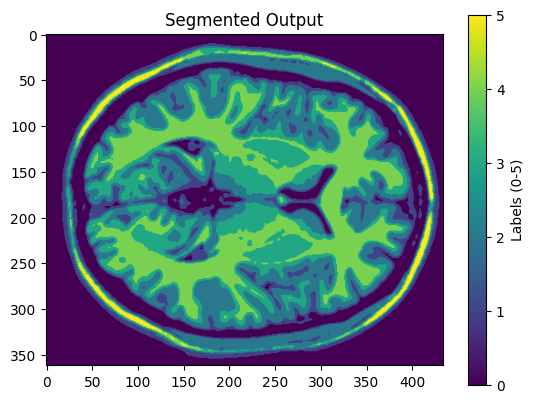

In [19]:
slice = T1.flatten().reshape(-1,1)
temporal_masks, segmented_img, dice_score, jaccard_score, accuracy_score = full_segmentation(slice)
print(f"Slice {slice}")
print(f"Dice Coefficient: {dice_score:.3f}")
print(f"Jaccard Index: {jaccard_score:.3f}")
print(f"Pixel Accuracy: {accuracy_score:.3f}")
# plot_masks(temporal_masks, rows=2, cols=4)
plt.imshow(segmented_img[...,1])
plt.title('Segmented Output')
plt.colorbar(ticks=range(6), label="Labels (0-5)")
plt.show()